# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense
from tensorflow.keras.layers import Dense, LSTM, Bidirectional


# Importing the Dataset



- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




In [2]:
# Define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['Mach Number', 'Altitude', 'Sea-level temperature']
sensor_names = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow"
]

col_names = index_names + setting_names + sensor_names

# Read data
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()


,unit_nr,time_cycles,Mach Number,Altitude,Sea-level temperature,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
train.shape

(20631, 26)

In [4]:
y_test.shape

(100, 1)

In [5]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each engine, 
therefore the test dataset will be subsetted to represent the same.

In [6]:
test.shape

(13096, 26)

In [7]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)

In [8]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [9]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 24)

# Data Pre-Processing + Data Visualization

In [10]:
train.describe()

,unit_nr,time_cycles,Mach Number,Altitude,Sea-level temperature,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [11]:
# Remove setting_3 column as we can see that it's value is not changing theerfore will not not add any information to our 
# prediction
train=train.drop('Sea-level temperature',axis=1)

In [12]:
# Adding RUL (Ramining Useful Life) to the train dataset
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),Engine pressure ratio (P50/P2),...,Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [13]:
train.head(5)

,unit_nr,time_cycles,Mach Number,Altitude,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),bypass-duct pressure (psia),...,Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,-0.0007,-0.0004,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


## Plotting of RUL

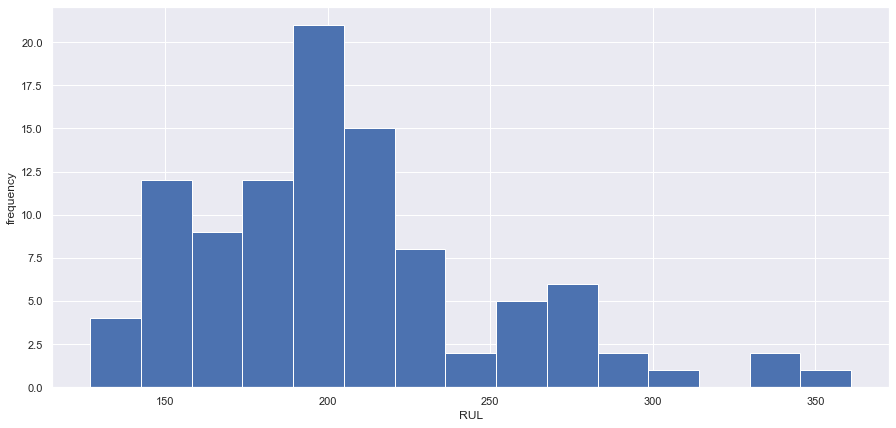

In [14]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

## Plotting of Sensor Values Vs RUL

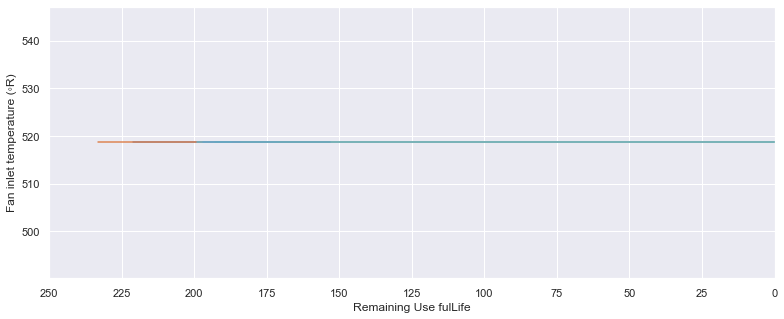

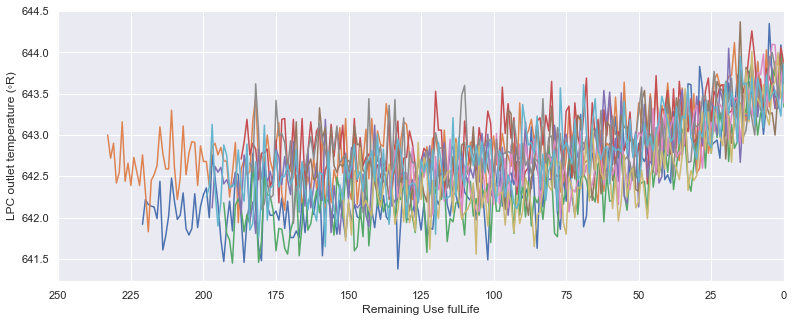

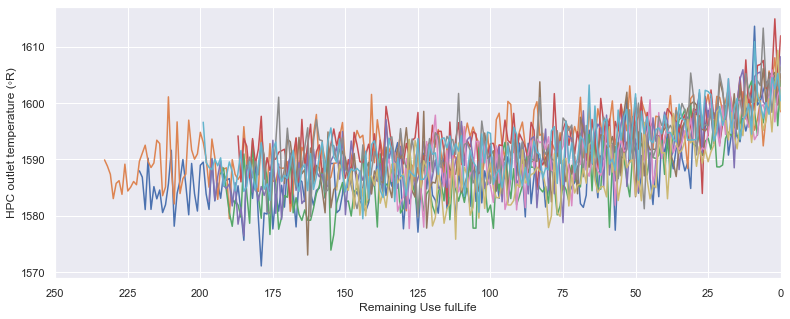

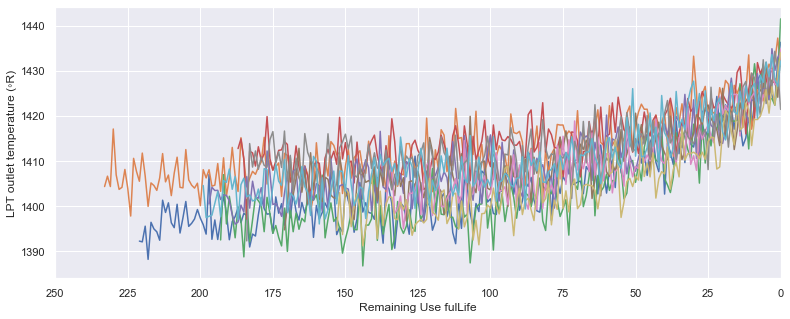

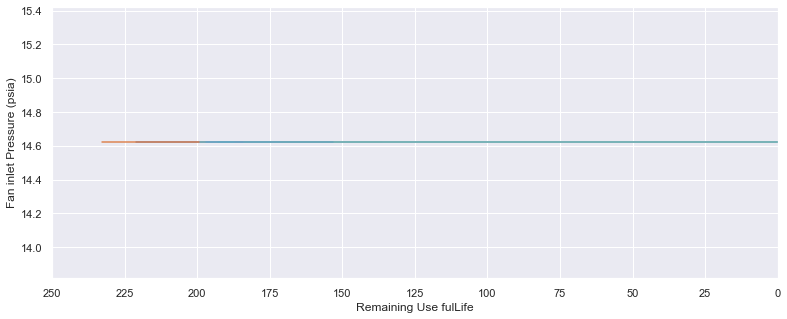

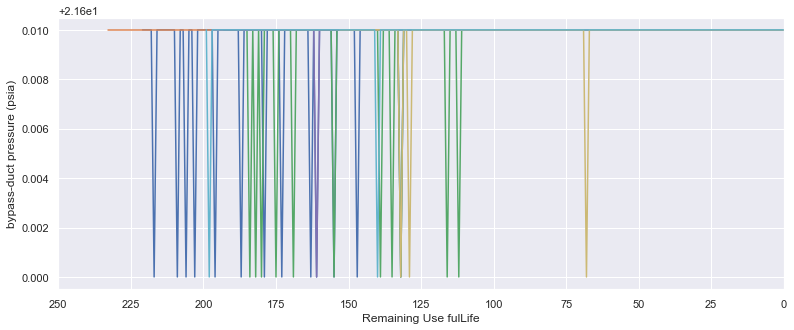

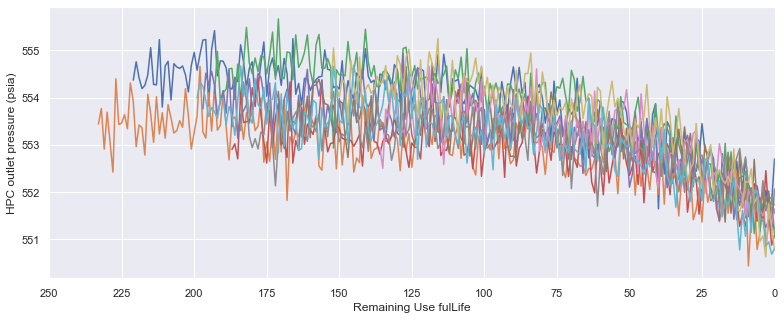

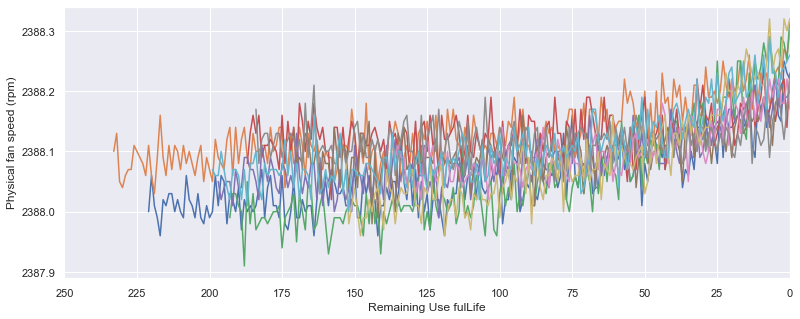

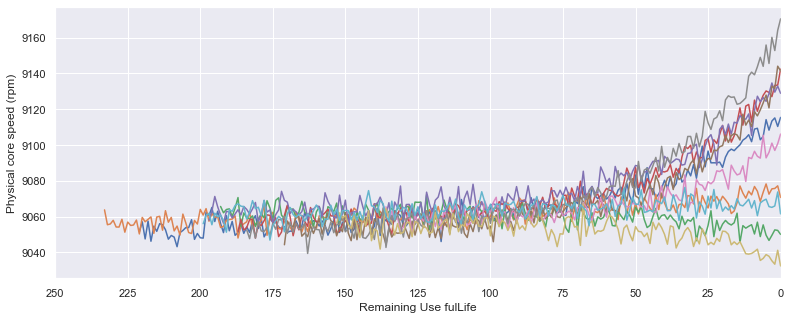

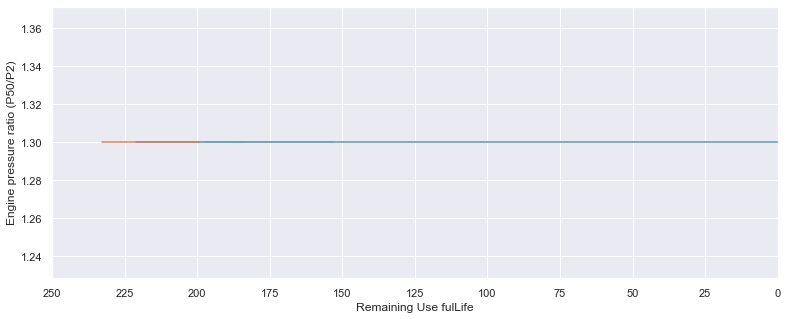

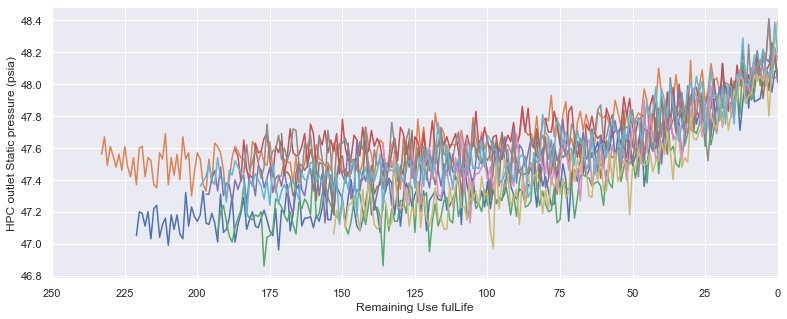

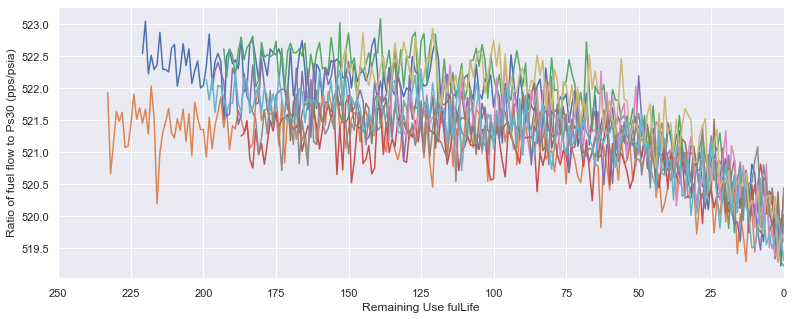

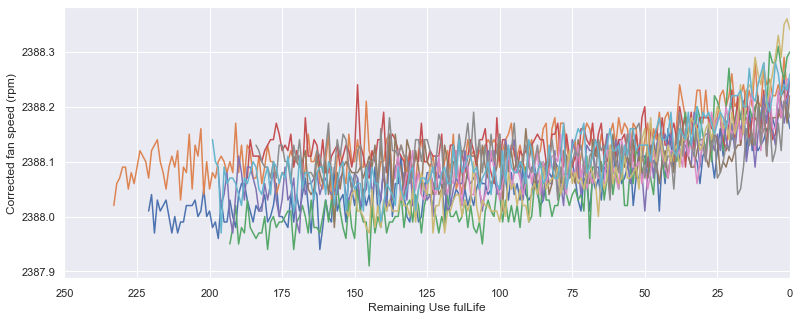

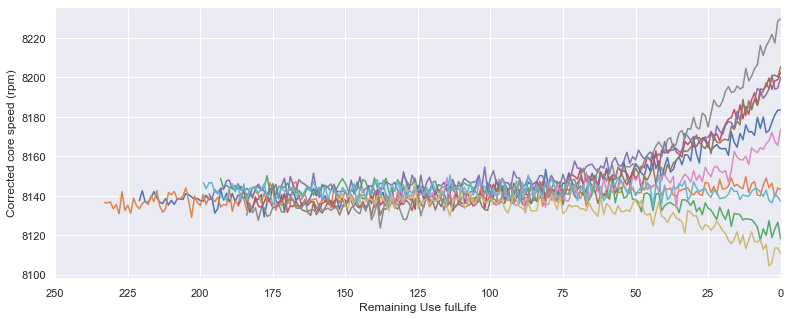

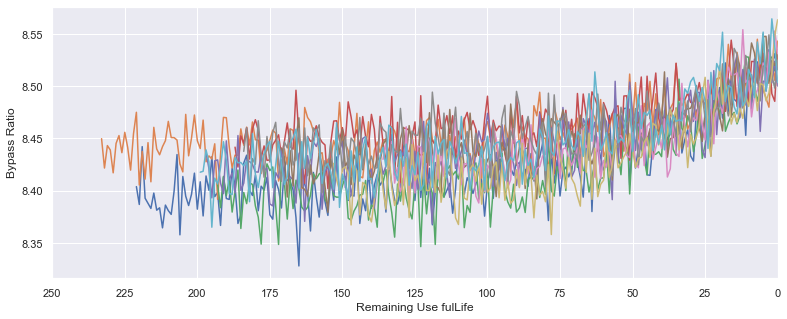

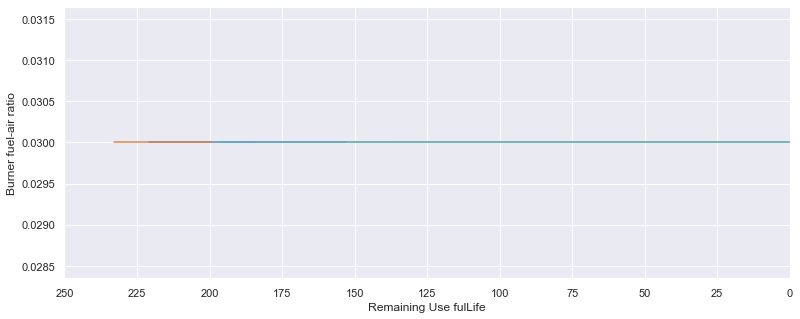

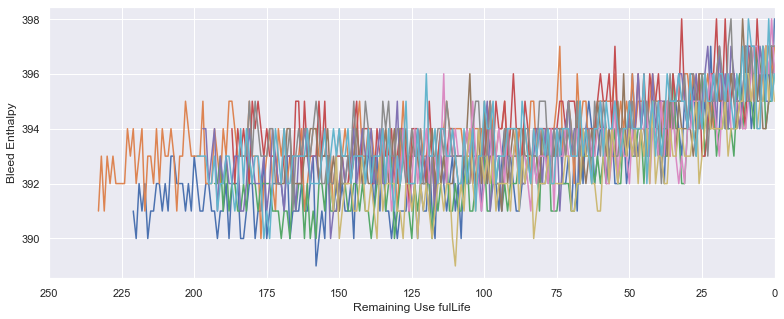

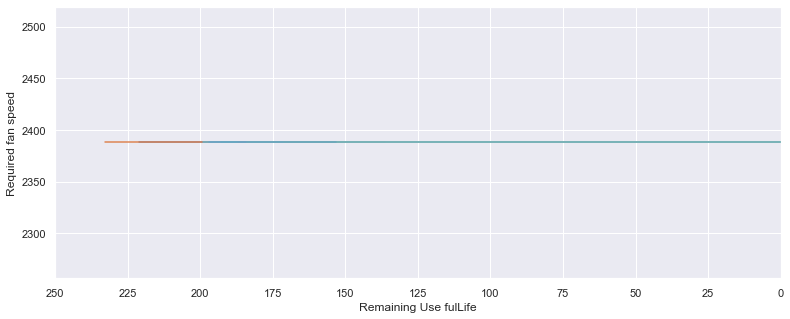

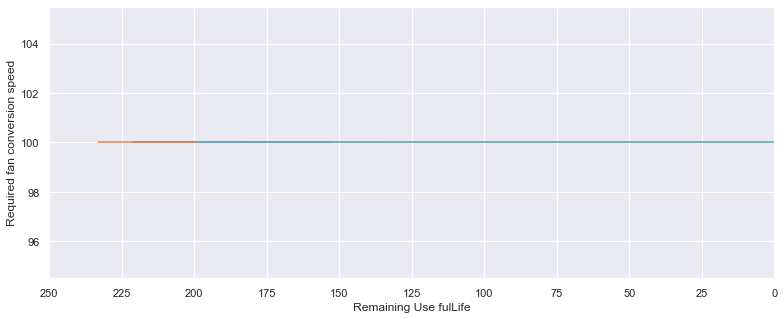

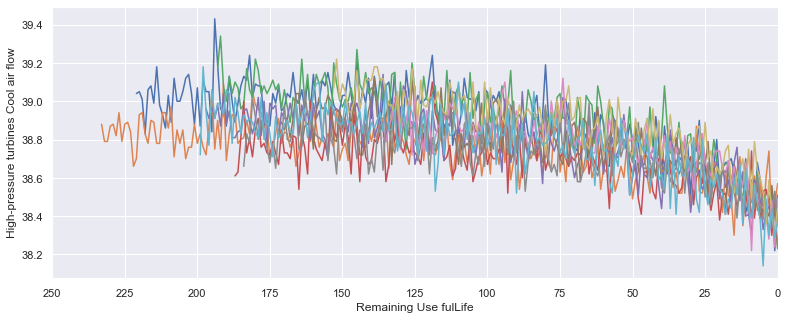

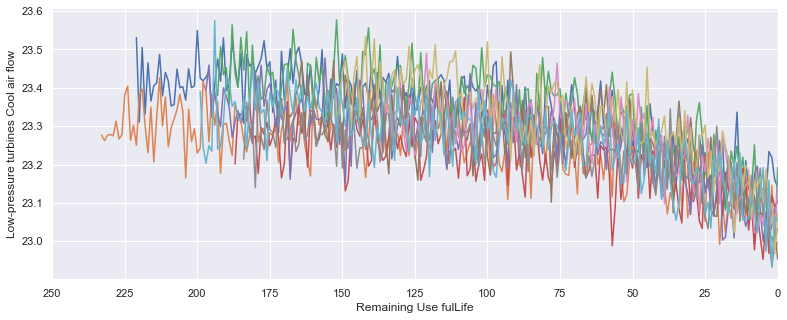

In [15]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Boxplots to find outliers

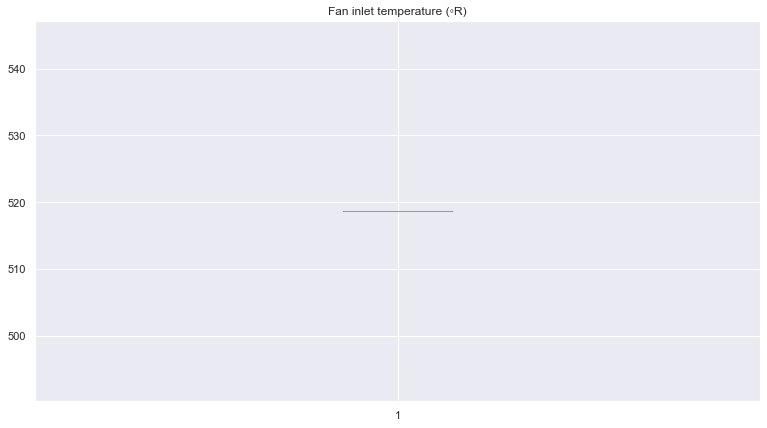

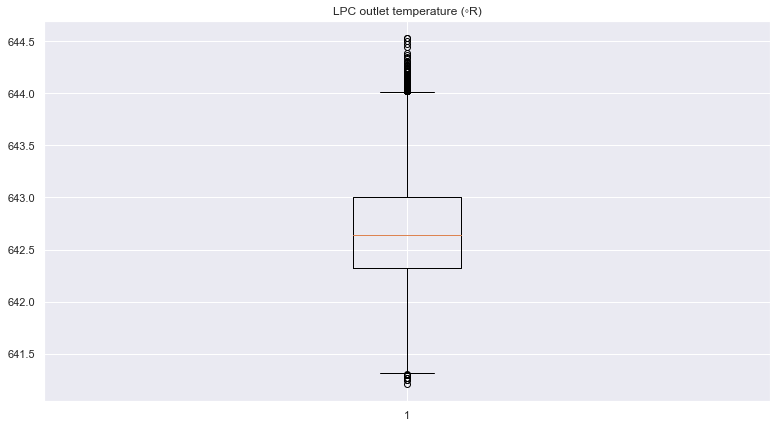

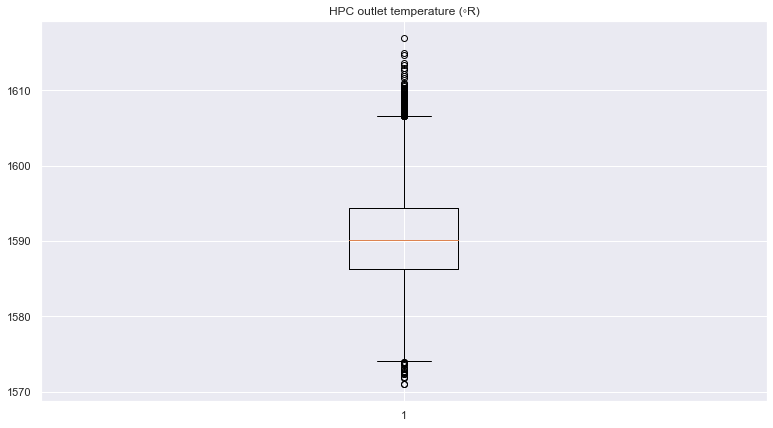

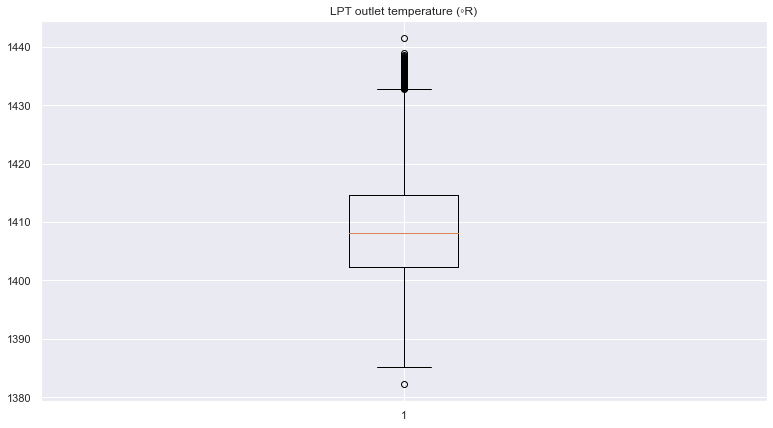

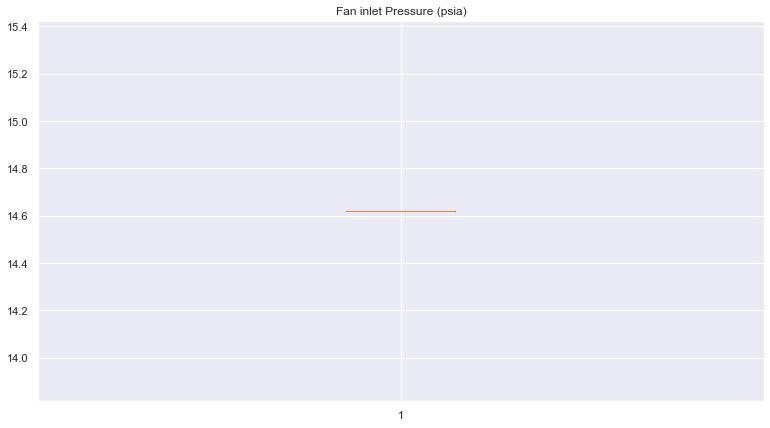

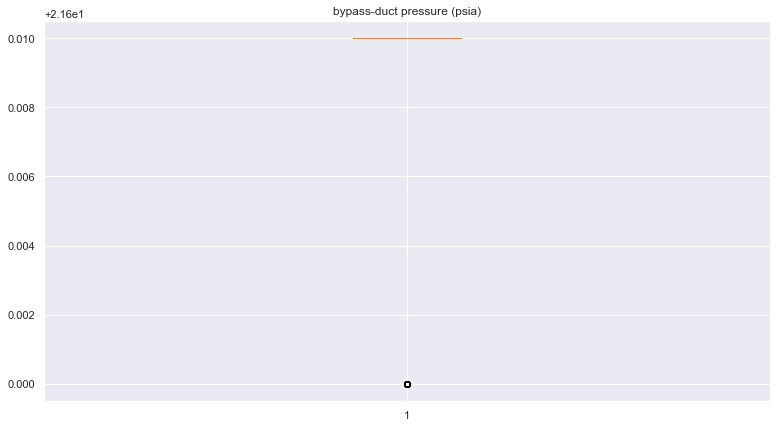

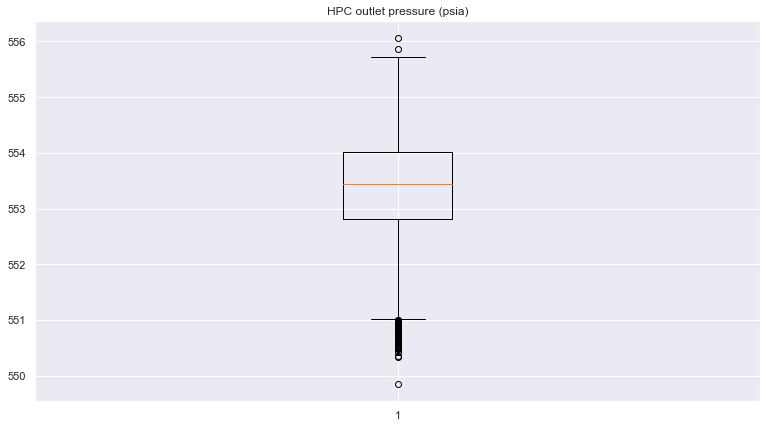

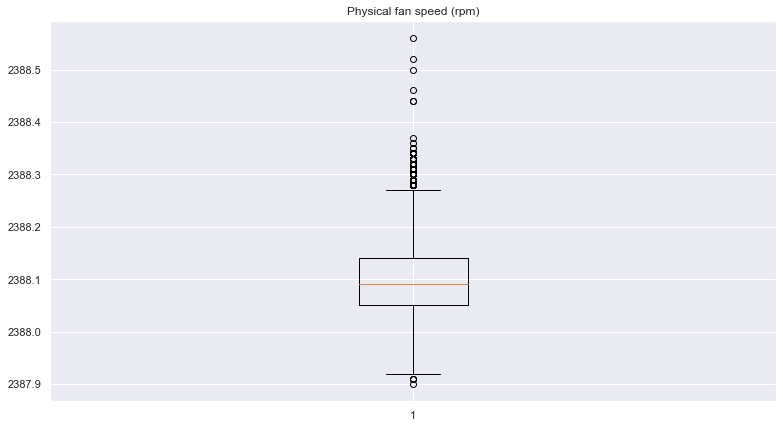

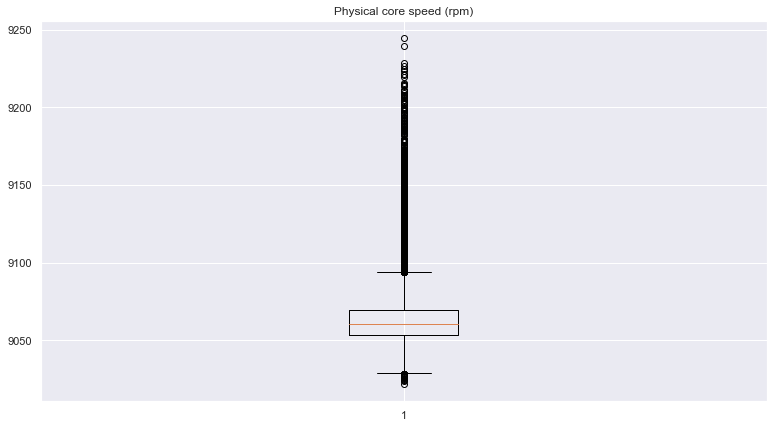

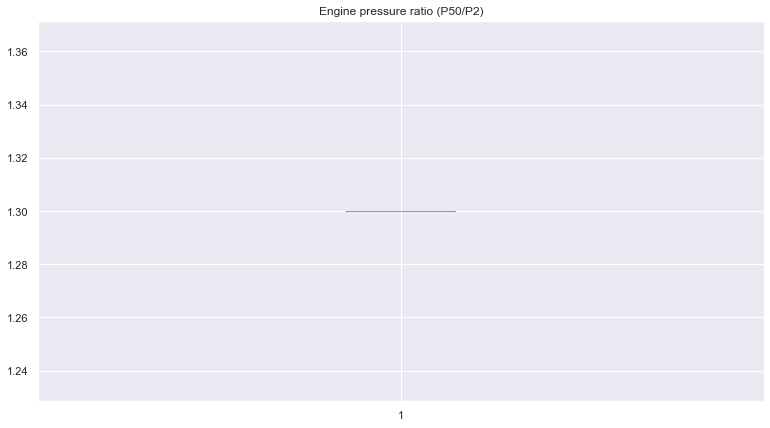

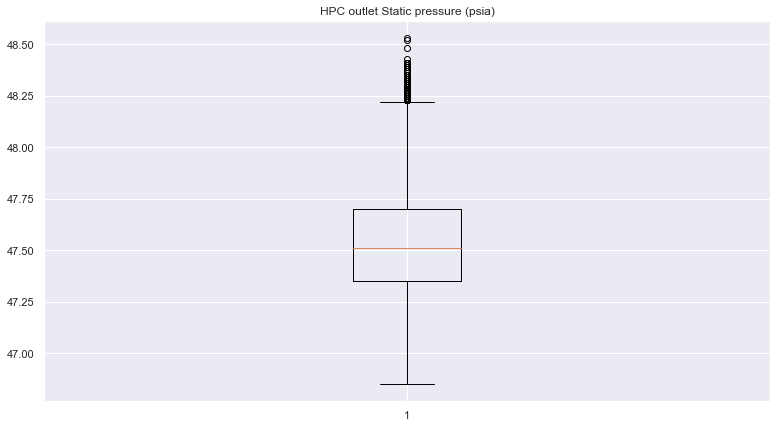

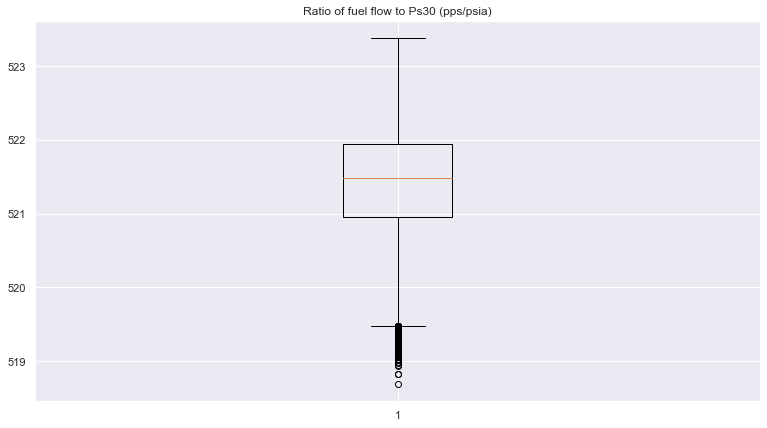

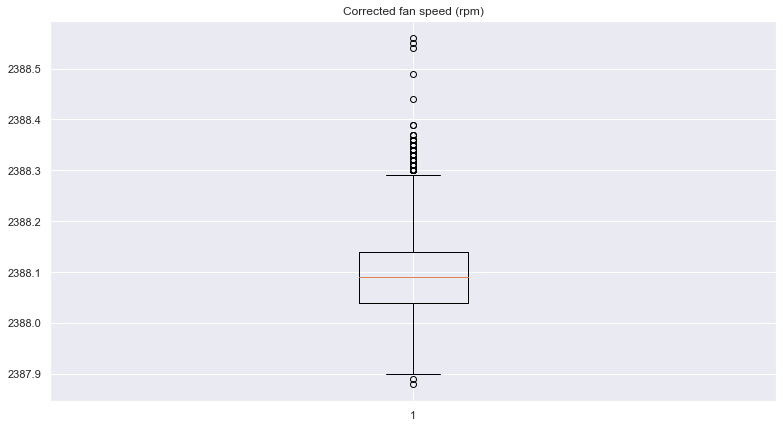

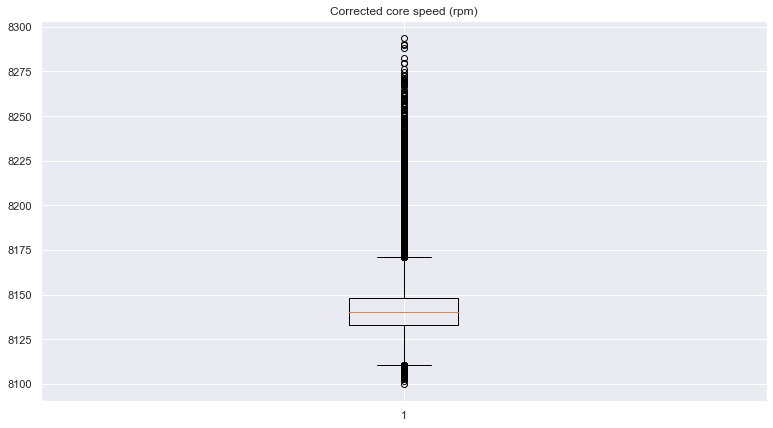

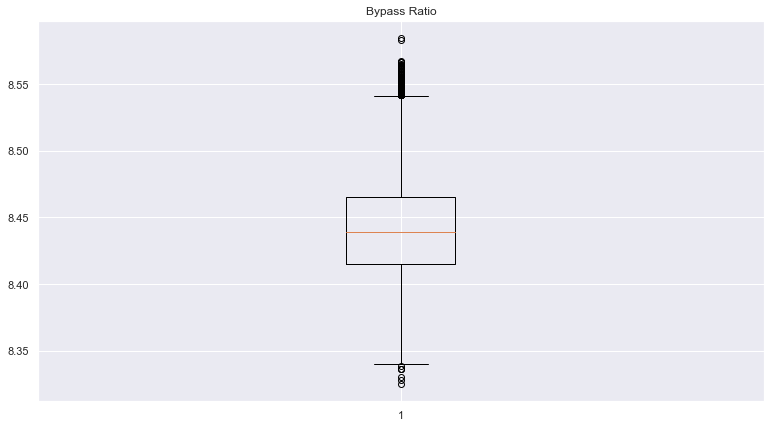

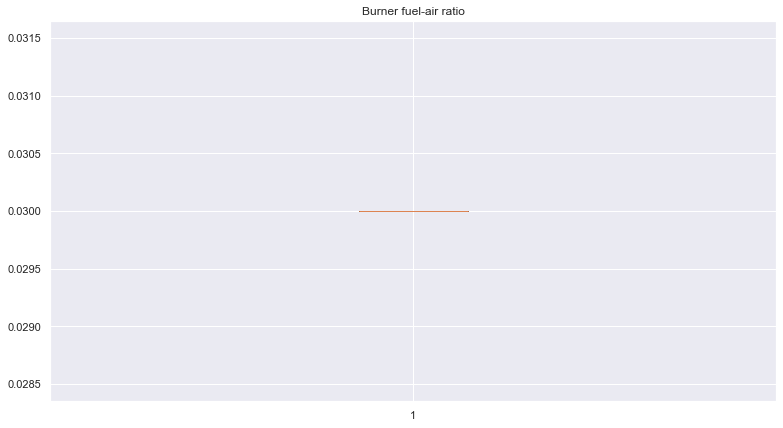

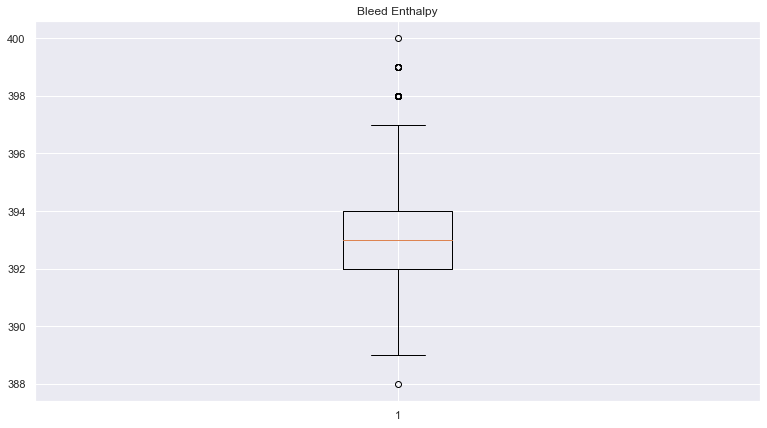

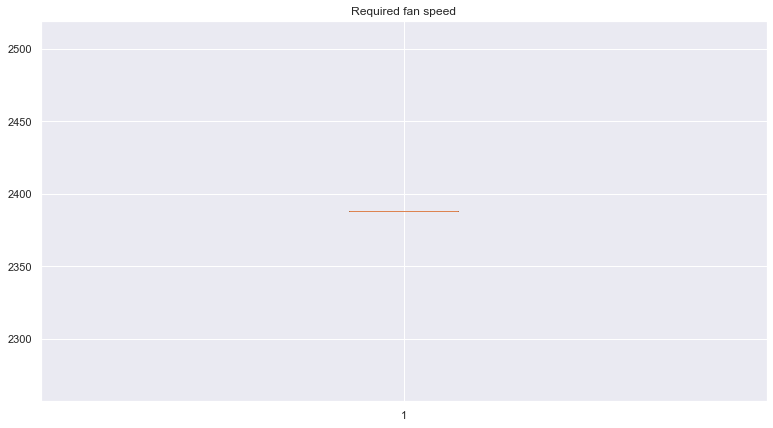

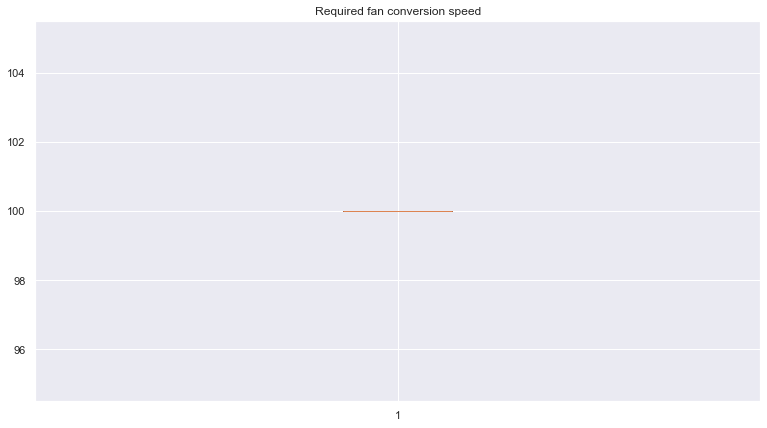

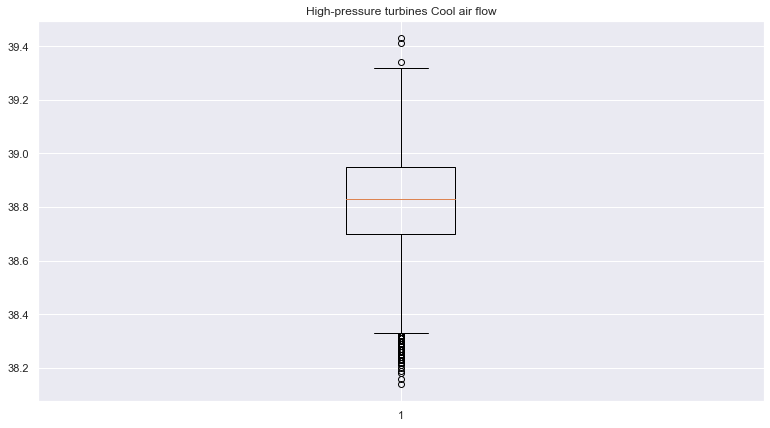

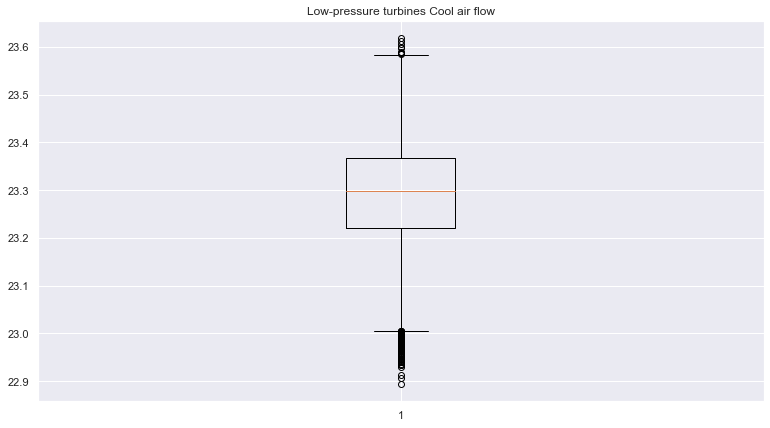

In [16]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

## Max time cycle found for each Unit

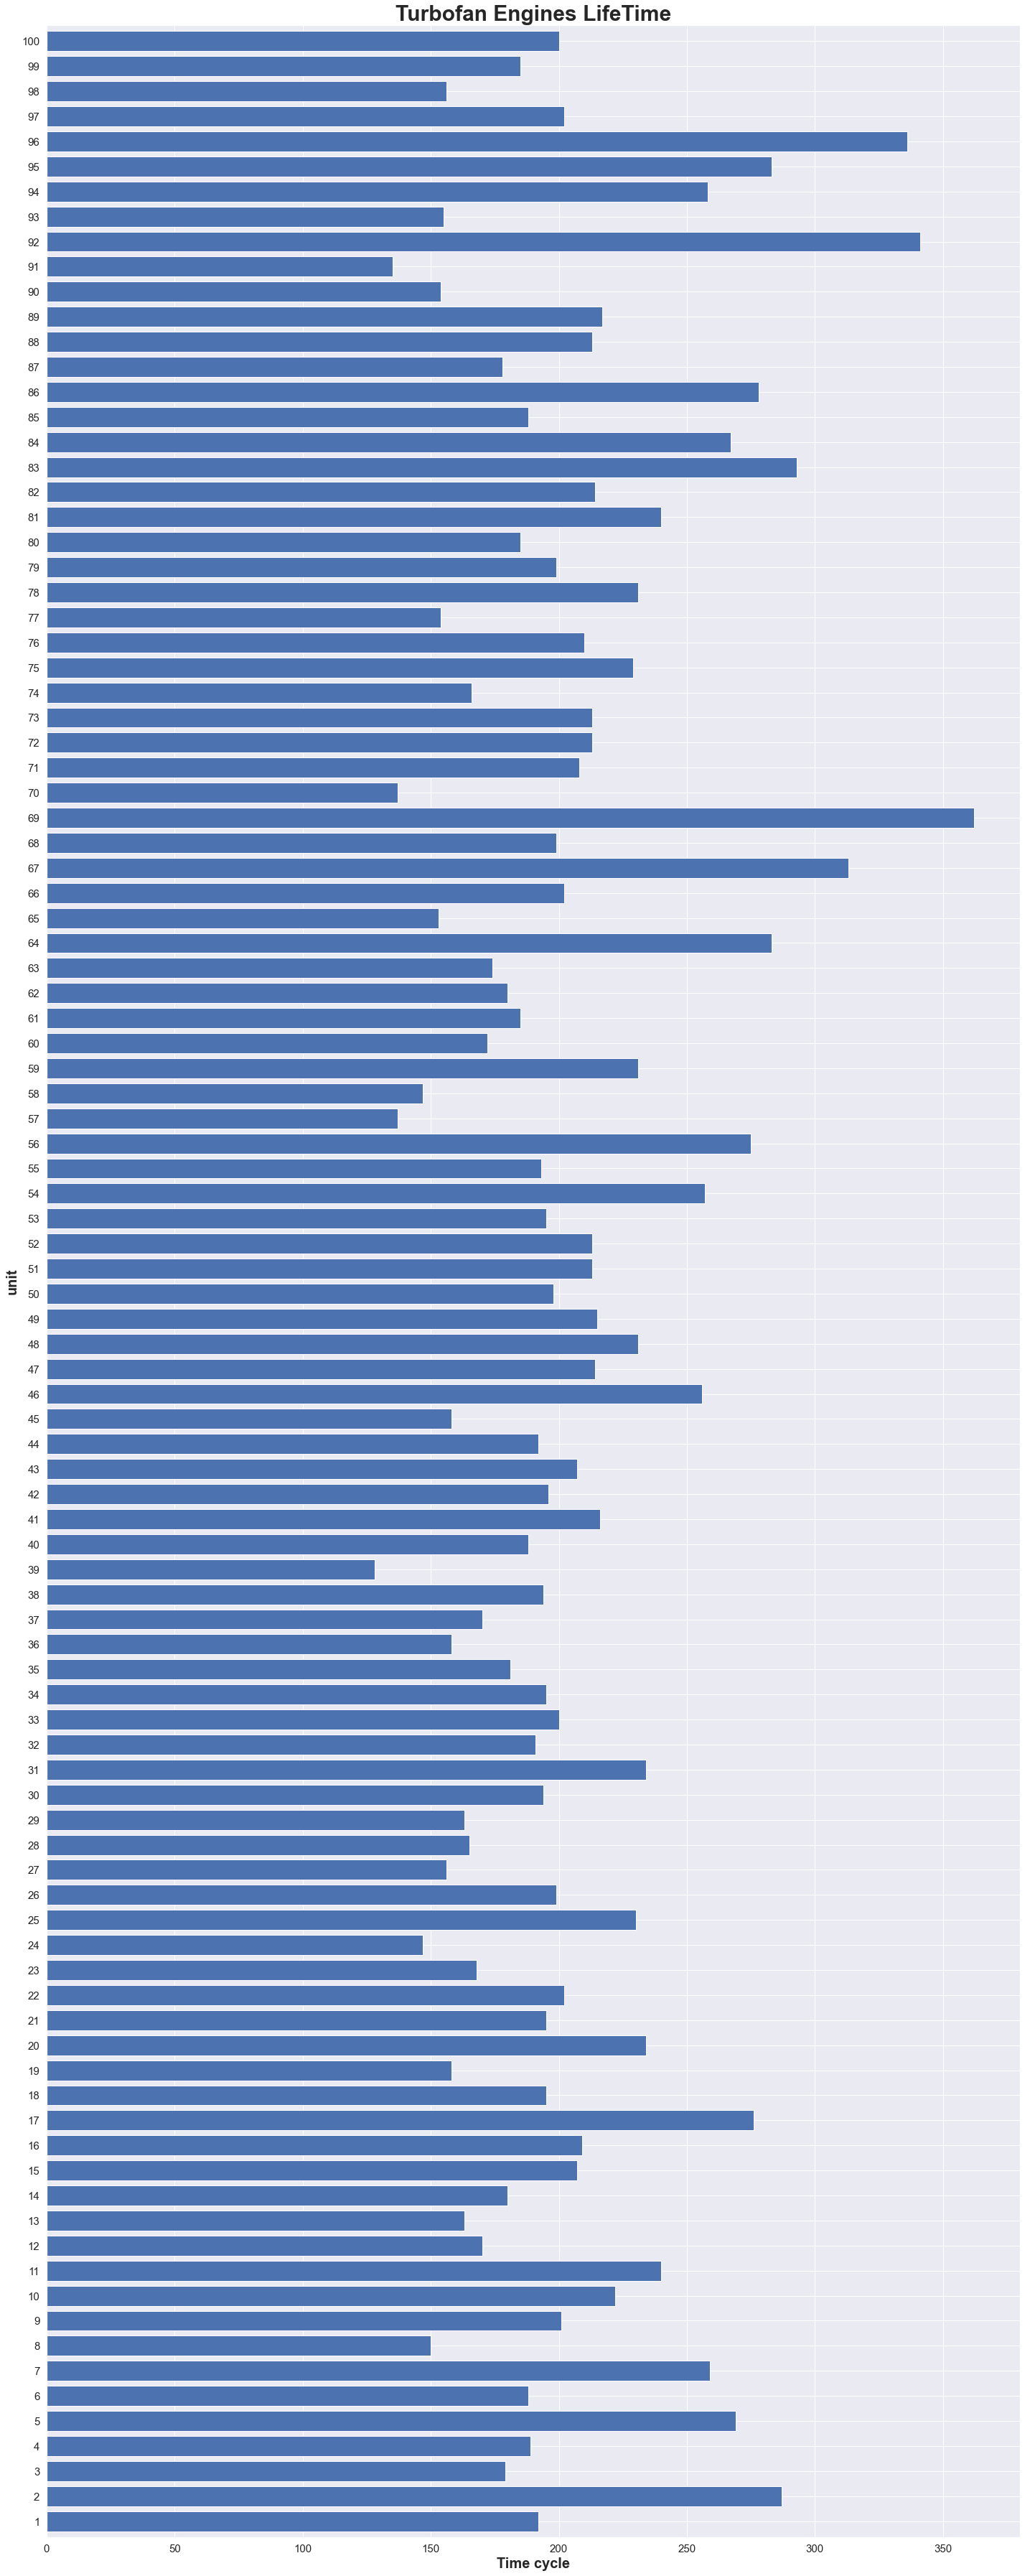

In [17]:
max_time_cycles=train[index_names].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.959999999999994, 'max time cycle')

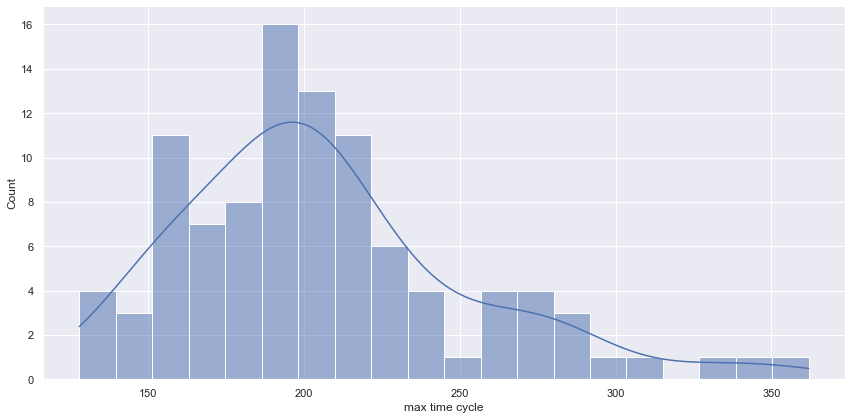

In [18]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [19]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

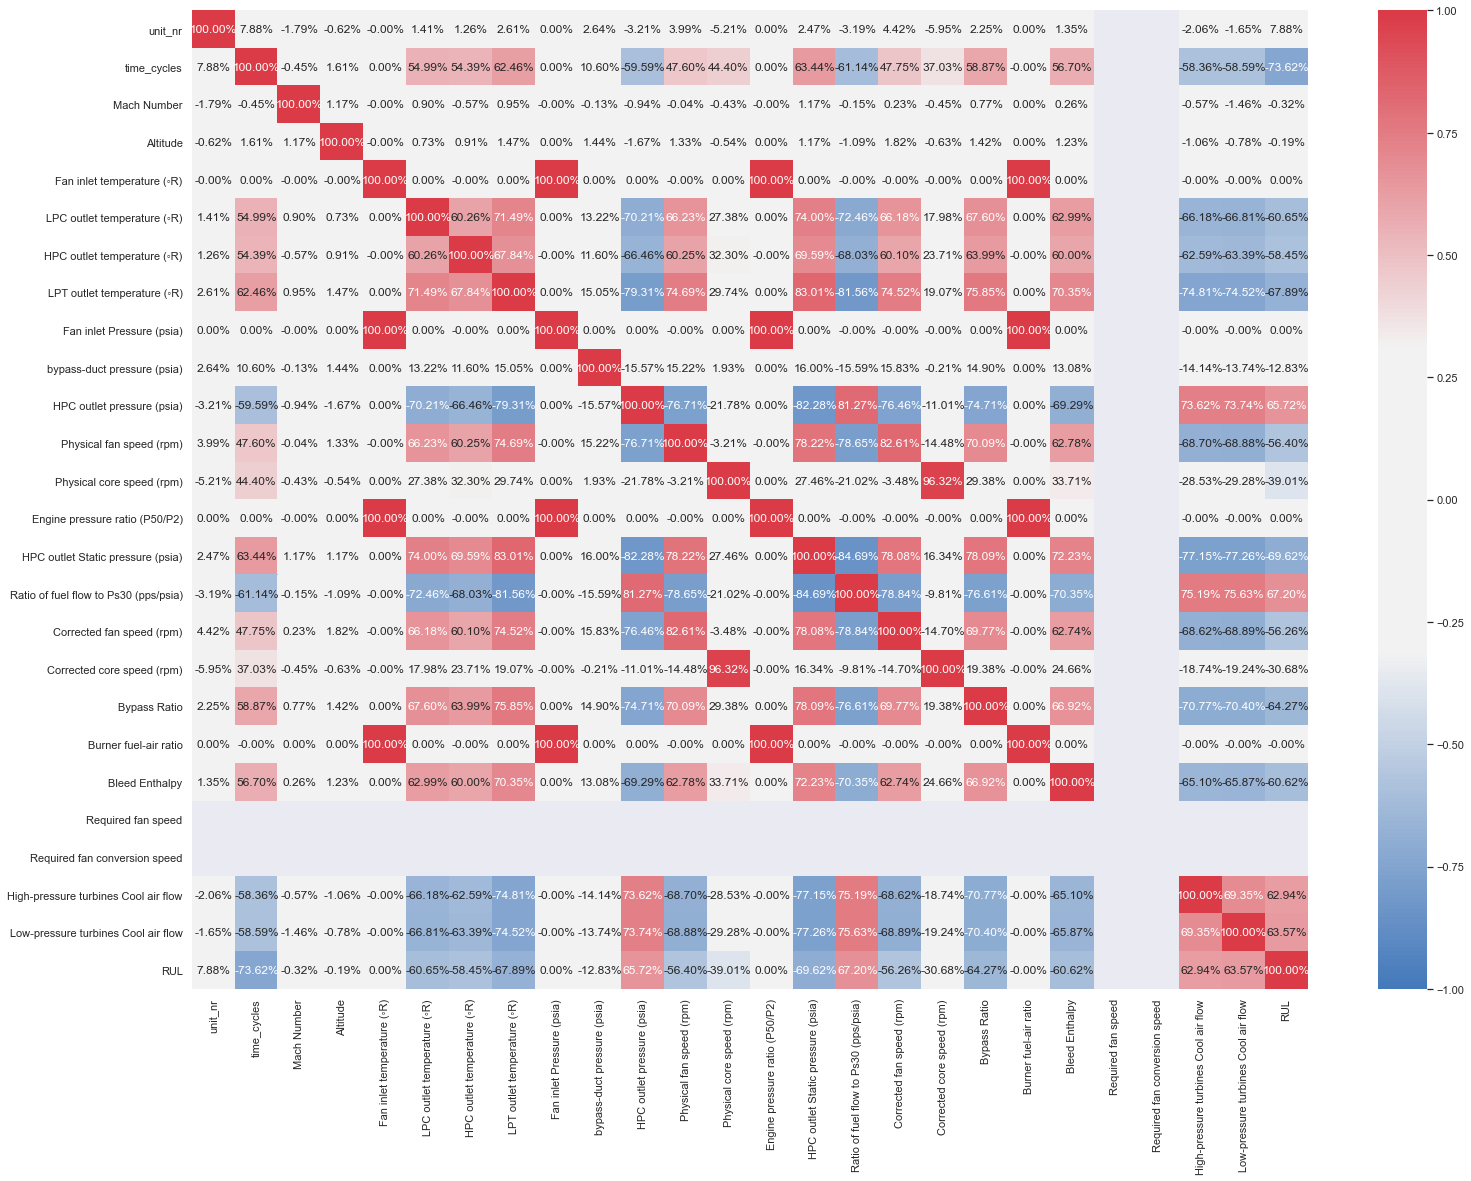

In [20]:

plt.figure(figsize=(25, 18))
correlation_matrix = train.corr()

# Define a custom color map with varying shades
cmap = sns.diverging_palette(250, 10, sep=80, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2%', vmin=-1, vmax=1)
plt.show()


In [21]:
cor=train.corr()
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

time_cycles                             -0.736241
LPC outlet temperature (◦R)             -0.606484
HPC outlet temperature (◦R)             -0.584520
LPT outlet temperature (◦R)             -0.678948
HPC outlet pressure (psia)               0.657223
Physical fan speed (rpm)                -0.563968
HPC outlet Static pressure (psia)       -0.696228
Ratio of fuel flow to Ps30 (pps/psia)    0.671983
Corrected fan speed (rpm)               -0.562569
Bypass Ratio                            -0.642667
Bleed Enthalpy                          -0.606154
High-pressure turbines Cool air flow     0.629428
Low-pressure turbines Cool air flow      0.635662
RUL                                      1.000000
Name: RUL, dtype: float64

In [22]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['LPC outlet temperature (◦R)', 'HPC outlet temperature (◦R)',
       'LPT outlet temperature (◦R)', 'HPC outlet pressure (psia)',
       'Physical fan speed (rpm)', 'HPC outlet Static pressure (psia)',
       'Ratio of fuel flow to Ps30 (pps/psia)', 'Corrected fan speed (rpm)',
       'Bypass Ratio', 'Bleed Enthalpy',
       'High-pressure turbines Cool air flow',
       'Low-pressure turbines Cool air flow', 'RUL'],
      dtype='object')

In [23]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [24]:
# Now we will keep onlt these imprtant features in both train & test dataset.
train=train[list_relevant_features]

In [25]:
train.head(5)

,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),HPC outlet pressure (psia),Physical fan speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


## Seperating Train & Test Data

In [26]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),HPC outlet pressure (psia),Physical fan speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044


In [27]:
test.head(5)

,Mach Number,Altitude,Sea-level temperature,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),bypass-duct pressure (psia),HPC outlet pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [28]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),HPC outlet pressure (psia),Physical fan speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,642.58,1581.22,1398.91,554.42,2388.08,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [29]:
y_test.head(5)

,RUL
0,112
1,98
2,69
3,82
4,91


In [30]:
y_train.describe()

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

In [31]:

y_train= y_train.clip(upper=103)
y_train.head(5)

0    103
1    103
2    103
3    103
4    103
Name: RUL, dtype: int64

In [32]:
y_test.describe()

,RUL
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


In [33]:
y_test= y_test.clip(upper=103)
y_test.head(5)

,RUL
0,103
1,98
2,69
3,82
4,91


## Building Model

In [34]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

## Bi-LSTM model

In [35]:
# Model: Bidirectional LSTM
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [36]:
# Preprocess data for LSTM
scaler_lstm = StandardScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

In [37]:
# Reshape input for LSTM 
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


In [38]:
# Build and train the Bidirectional LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
bilstm_model = build_bilstm_model(input_shape)


In [39]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [40]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
516/516 [==============================] - 4s 3ms/step - loss: 4269.4756 - mae: 55.8342 - val_loss: 2307.5928 - val_mae: 38.6943
Epoch 2/50
516/516 [==============================] - 1s 3ms/step - loss: 1715.4746 - mae: 32.6991 - val_loss: 930.7142 - val_mae: 24.2513
Epoch 3/50
516/516 [==============================] - 1s 3ms/step - loss: 628.8132 - mae: 19.8702 - val_loss: 387.8479 - val_mae: 15.6249
Epoch 4/50
516/516 [==============================] - 1s 3ms/step - loss: 296.2062 - mae: 13.5645 - val_loss: 262.4712 - val_mae: 12.3552
Epoch 5/50
516/516 [==============================] - 1s 2ms/step - loss: 243.3709 - mae: 11.7230 - val_loss: 246.2554 - val_mae: 11.5705
Epoch 6/50
516/516 [==============================] - 1s 2ms/step - loss: 237.6017 - mae: 11.3104 - val_loss: 244.1734 - val_mae: 11.3790
Epoch 7/50
516/516 [==============================] - 1s 2ms/step - loss: 235.8639 - mae: 11.1872 - val_loss: 242.9075 - val_mae: 11.3272
Epoch 8/50
516/516 [===========

In [41]:
# Evaluate on train data
y_hat_train_lstm = bilstm_model.predict(X_train_lstm)
RMSE_Train_LSTM, R2_Train_LSTM = evaluate(y_train, y_hat_train_lstm, 'train')

645/645 [==============================] - 1s 1ms/step
train set RMSE:14.941363926906034, R2:0.8001991431821298


In [42]:
# Evaluate on test data
y_hat_test_lstm = bilstm_model.predict(X_test_lstm)
RMSE_Test_LSTM, R2_Test_LSTM = evaluate(y_test, y_hat_test_lstm, 'test')


4/4 [==============================] - 0s 6ms/step
test set RMSE:14.972683504444138, R2:0.8178042327858115


In [43]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model': ['BiLSTM'],
    'RMSE-Train': [RMSE_Train_LSTM],
    'R2-Train': [R2_Train_LSTM],
    'RMSE-Test': [RMSE_Test_LSTM],
    'R2-Test': [R2_Test_LSTM]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804


## Bi-TRNN model

In [44]:
# Model: Bidirectional TRNN 
def Bi_trnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [45]:
# Preprocess data for Bi-TRNN
scaler_bi_trnn = StandardScaler()
X_train_bi_trnn = scaler_bi_trnn.fit_transform(X_train)
X_test_bi_trnn = scaler_bi_trnn.transform(X_test)

In [46]:
# Reshape input for Bi-TRNN 
X_train_bi_trnn = X_train_bi_trnn.reshape((X_train_bi_trnn.shape[0], X_train_bi_trnn.shape[1], 1))
X_test_bi_trnn = X_test_bi_trnn.reshape((X_test_bi_trnn.shape[0], X_test_bi_trnn.shape[1], 1))


In [47]:
# Build and train the Bidirectional TRNN model
input_shape_bi_trnn = (X_train_bi_trnn.shape[1], X_train_bi_trnn.shape[2])
bi_trnn_model = Bi_trnn(input_shape_bi_trnn)

# Define early stopping to prevent overfitting
early_stopping_bi_trnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [48]:
# Train the model
bi_trnn_model.fit(X_train_bi_trnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_trnn])


Epoch 1/50
516/516 [==============================] - 4s 5ms/step - loss: 926.7861 - mae: 20.3866 - val_loss: 290.4350 - val_mae: 13.6500
Epoch 2/50
516/516 [==============================] - 2s 4ms/step - loss: 267.8333 - mae: 12.3342 - val_loss: 281.3230 - val_mae: 13.6302
Epoch 3/50
516/516 [==============================] - 2s 4ms/step - loss: 258.1763 - mae: 11.9898 - val_loss: 248.5308 - val_mae: 10.8847
Epoch 4/50
516/516 [==============================] - 2s 4ms/step - loss: 257.8819 - mae: 12.0137 - val_loss: 252.4415 - val_mae: 10.8956
Epoch 5/50
516/516 [==============================] - 2s 4ms/step - loss: 244.9358 - mae: 11.5119 - val_loss: 245.0840 - val_mae: 10.7659
Epoch 6/50
516/516 [==============================] - 2s 4ms/step - loss: 246.2648 - mae: 11.6078 - val_loss: 266.1925 - val_mae: 11.2277
Epoch 7/50
516/516 [==============================] - 2s 4ms/step - loss: 245.3587 - mae: 11.5452 - val_loss: 247.1034 - val_mae: 10.6844
Epoch 8/50
516/516 [==============

In [49]:
# Evaluate on train data
y_hat_train_bi_trnn = bi_trnn_model.predict(X_train_bi_trnn)
RMSE_Train_BiTRNN, R2_Train_BiTRNN = evaluate(y_train, y_hat_train_bi_trnn, 'train')



645/645 [==============================] - 1s 2ms/step
train set RMSE:15.060651507138145, R2:0.7969961020377079


In [50]:
# Evaluate on test data
y_hat_test_bi_trnn = bi_trnn_model.predict(X_test_bi_trnn)
RMSE_Test_BiTRNN, R2_Test_BiTRNN = evaluate(y_test, y_hat_test_bi_trnn, 'test')


4/4 [==============================] - 0s 3ms/step
test set RMSE:15.046288353046014, R2:0.8160085019857846


In [51]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiTRNN'],
    'RMSE-Train': [RMSE_Train_BiTRNN],
    'R2-Train': [R2_Train_BiTRNN],
    'RMSE-Test': [RMSE_Test_BiTRNN],
    'R2-Test': [R2_Test_BiTRNN]
}), ignore_index=True)

# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804
1,BiTRNN,15.060652,0.796996,15.046288,0.816009


## Bi-GRU model

In [52]:
# Model: Bidirectional GRU (Bi-GRU)
def build_bi_gru_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [53]:
# Preprocess data for GRU
scaler_bi_gru = StandardScaler()
X_train_bi_gru = scaler_bi_gru.fit_transform(X_train)
X_test_bi_gru = scaler_bi_gru.transform(X_test)


In [54]:
# Reshape input for GRU 
X_train_bi_gru = X_train_bi_gru.reshape((X_train_bi_gru.shape[0], 1, X_train_bi_gru.shape[1]))
X_test_bi_gru = X_test_bi_gru.reshape((X_test_bi_gru.shape[0], 1, X_test_bi_gru.shape[1]))


In [55]:
# Build and train the Bidirectional GRU model
input_shape_bi_gru = (X_train_bi_gru.shape[1], X_train_bi_gru.shape[2])
bi_gru_model = build_bi_gru_model(input_shape_bi_gru)


In [56]:
# Define early stopping to prevent overfitting
early_stopping_bi_gru = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [57]:
# Train the model
bi_gru_model.fit(X_train_bi_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_gru])


Epoch 1/50
516/516 [==============================] - 4s 3ms/step - loss: 3641.7932 - mae: 50.8559 - val_loss: 1359.4154 - val_mae: 29.2882
Epoch 2/50
516/516 [==============================] - 1s 2ms/step - loss: 578.0549 - mae: 18.3611 - val_loss: 264.5029 - val_mae: 12.4734
Epoch 3/50
516/516 [==============================] - 1s 2ms/step - loss: 241.3699 - mae: 11.6822 - val_loss: 243.5388 - val_mae: 11.2780
Epoch 4/50
516/516 [==============================] - 1s 2ms/step - loss: 235.3834 - mae: 11.2798 - val_loss: 242.0468 - val_mae: 11.3281
Epoch 5/50
516/516 [==============================] - 1s 2ms/step - loss: 232.1164 - mae: 11.0965 - val_loss: 238.1070 - val_mae: 11.1864
Epoch 6/50
516/516 [==============================] - 1s 2ms/step - loss: 229.4861 - mae: 10.9881 - val_loss: 236.0352 - val_mae: 10.9099
Epoch 7/50
516/516 [==============================] - 1s 2ms/step - loss: 226.6733 - mae: 10.8347 - val_loss: 234.2947 - val_mae: 10.9226
Epoch 8/50
516/516 [============

In [58]:
# Evaluate on train data
y_hat_train_bi_gru = bi_gru_model.predict(X_train_bi_gru)
RMSE_Train_BiGRU, R2_Train_BiGRU = evaluate(y_train, y_hat_train_bi_gru, 'train')


645/645 [==============================] - 1s 1ms/step
train set RMSE:14.989112684456012, R2:0.7989200783258602


In [59]:
# Evaluate on test data
y_hat_test_bi_gru = bi_gru_model.predict(X_test_bi_gru)
RMSE_Test_BiGRU, R2_Test_BiGRU = evaluate(y_test, y_hat_test_bi_gru, 'test')


4/4 [==============================] - 0s 5ms/step
test set RMSE:14.819137677305369, R2:0.8215219304199959


In [60]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiGRU'],
    'RMSE-Train': [RMSE_Train_BiGRU],
    'R2-Train': [R2_Train_BiGRU],
    'RMSE-Test': [RMSE_Test_BiGRU],
    'R2-Test': [R2_Test_BiGRU]
}), ignore_index=True)


In [61]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804
1,BiTRNN,15.060652,0.796996,15.046288,0.816009
2,BiGRU,14.989113,0.798920,14.819138,0.821522


## ProgNet model

In [62]:

# Model: ProgNet (Progressive Neural Network) 
def build_prognet_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [63]:
# Preprocess data for ProgNet
scaler_prognet = StandardScaler()
X_train_prognet = scaler_prognet.fit_transform(X_train)
X_test_prognet = scaler_prognet.transform(X_test)


In [64]:
# Reshape input for LSTM 
X_train_prognet = X_train_prognet.reshape((X_train_prognet.shape[0], X_train_prognet.shape[1], 1))

# Build and train the ProgNet model
input_shape_prognet = (X_train_prognet.shape[1], X_train_prognet.shape[2])
prognet_model = build_prognet_model(input_shape_prognet)


In [65]:
# Define early stopping to prevent overfitting
early_stopping_prognet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [66]:
# Train the model
prognet_model.fit(X_train_prognet, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_prognet])


Epoch 1/50
516/516 [==============================] - 7s 9ms/step - loss: 998.4295 - mae: 21.5699 - val_loss: 314.6457 - val_mae: 13.6830
Epoch 2/50
516/516 [==============================] - 4s 9ms/step - loss: 328.0074 - mae: 13.6936 - val_loss: 289.6031 - val_mae: 11.7855
Epoch 3/50
516/516 [==============================] - 4s 8ms/step - loss: 309.2169 - mae: 13.4240 - val_loss: 279.8760 - val_mae: 12.9970
Epoch 4/50
516/516 [==============================] - 4s 8ms/step - loss: 287.2159 - mae: 12.9272 - val_loss: 281.7965 - val_mae: 13.3372
Epoch 5/50
516/516 [==============================] - 4s 8ms/step - loss: 273.0345 - mae: 12.4591 - val_loss: 258.9589 - val_mae: 11.5703
Epoch 6/50
516/516 [==============================] - 4s 8ms/step - loss: 265.9398 - mae: 12.2093 - val_loss: 255.2954 - val_mae: 11.0470
Epoch 7/50
516/516 [==============================] - 4s 8ms/step - loss: 261.2839 - mae: 12.0568 - val_loss: 257.0187 - val_mae: 11.4850
Epoch 8/50
516/516 [==============

In [67]:
# Evaluate on train data
y_hat_train_prognet = prognet_model.predict(X_train_prognet)
RMSE_Train_ProgNet, R2_Train_ProgNet = evaluate(y_train, y_hat_train_prognet, 'train')


645/645 [==============================] - 2s 3ms/step
train set RMSE:14.945586399148997, R2:0.8000861986362879


In [68]:
# Reshape input for LSTM 
X_test_prognet = X_test_prognet.reshape((X_test_prognet.shape[0], X_test_prognet.shape[1], 1))

# Evaluate on test data
y_hat_test_prognet = prognet_model.predict(X_test_prognet)

# Now you can proceed with the evaluation
RMSE_Test_ProgNet, R2_Test_ProgNet = evaluate(y_test, y_hat_test_prognet, 'test')


4/4 [==============================] - 0s 6ms/step
test set RMSE:14.867225053415016, R2:0.8203617459057861


In [69]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['ProgNet'],
    'RMSE-Train': [RMSE_Train_ProgNet],
    'R2-Train': [R2_Train_ProgNet],
    'RMSE-Test': [RMSE_Test_ProgNet],
    'R2-Test': [R2_Test_ProgNet]
}), ignore_index=True)

In [70]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804
1,BiTRNN,15.060652,0.796996,15.046288,0.816009
2,BiGRU,14.989113,0.798920,14.819138,0.821522
3,ProgNet,14.945586,0.800086,14.867225,0.820362


## DCNN model

In [71]:
# Model: Deep Convolutional Neural Network (DCNN)
def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [72]:
# Preprocess data for DCNN
scaler_dcnn = StandardScaler()
X_train_dcnn = scaler_dcnn.fit_transform(X_train)
X_test_dcnn = scaler_dcnn.transform(X_test)

In [73]:
# Reshape input for DCNN 
X_train_dcnn = X_train_dcnn.reshape((X_train_dcnn.shape[0], X_train_dcnn.shape[1], 1))
X_test_dcnn = X_test_dcnn.reshape((X_test_dcnn.shape[0], X_test_dcnn.shape[1], 1))


In [74]:
# Build and train the DCNN model
input_shape_dcnn = (X_train_dcnn.shape[1], X_train_dcnn.shape[2])
dcnn_model = build_dcnn_model(input_shape_dcnn)

In [75]:
# Define early stopping to prevent overfitting
early_stopping_dcnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [76]:
# Train the model
dcnn_model.fit(X_train_dcnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dcnn])


Epoch 1/50
516/516 [==============================] - 2s 2ms/step - loss: 1425.4071 - mae: 28.4709 - val_loss: 305.8246 - val_mae: 13.3506
Epoch 2/50
516/516 [==============================] - 1s 2ms/step - loss: 300.2387 - mae: 13.3445 - val_loss: 268.4066 - val_mae: 12.3441
Epoch 3/50
516/516 [==============================] - 1s 2ms/step - loss: 277.8613 - mae: 12.6063 - val_loss: 277.3498 - val_mae: 13.1521
Epoch 4/50
516/516 [==============================] - 1s 2ms/step - loss: 269.5927 - mae: 12.3351 - val_loss: 258.1000 - val_mae: 11.5840
Epoch 5/50
516/516 [==============================] - 1s 2ms/step - loss: 265.8483 - mae: 12.2104 - val_loss: 256.0870 - val_mae: 11.8539
Epoch 6/50
516/516 [==============================] - 1s 2ms/step - loss: 260.3528 - mae: 12.0232 - val_loss: 254.4576 - val_mae: 11.6647
Epoch 7/50
516/516 [==============================] - 1s 2ms/step - loss: 257.8462 - mae: 11.9322 - val_loss: 248.6870 - val_mae: 11.1036
Epoch 8/50
516/516 [=============

In [77]:
# Evaluate on train data
y_hat_train_dcnn = dcnn_model.predict(X_train_dcnn)
RMSE_Train_DCNN, R2_Train_DCNN = evaluate(y_train, y_hat_train_dcnn, 'train')


645/645 [==============================] - 1s 1ms/step
train set RMSE:15.587236460808658, R2:0.7825521560604042


In [78]:
# Evaluate on test data
y_hat_test_dcnn = dcnn_model.predict(X_test_dcnn)
RMSE_Test_DCNN, R2_Test_DCNN = evaluate(y_test, y_hat_test_dcnn, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:15.587694482418115, R2:0.8025292551249826


In [79]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['DCNN'],
    'RMSE-Train': [RMSE_Train_DCNN],
    'R2-Train': [R2_Train_DCNN],
    'RMSE-Test': [RMSE_Test_DCNN],
    'R2-Test': [R2_Test_DCNN]
}), ignore_index=True)

In [80]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804
1,BiTRNN,15.060652,0.796996,15.046288,0.816009
2,BiGRU,14.989113,0.798920,14.819138,0.821522
3,ProgNet,14.945586,0.800086,14.867225,0.820362
4,DCNN,15.587236,0.782552,15.587694,0.802529


## Individual model result

In [81]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804
1,BiTRNN,15.060652,0.796996,15.046288,0.816009
2,BiGRU,14.989113,0.798920,14.819138,0.821522
3,ProgNet,14.945586,0.800086,14.867225,0.820362
4,DCNN,15.587236,0.782552,15.587694,0.802529


## Ensemble model using Random Forest Regressor

In [82]:
# Concatenate predictions from all base learners for training data
X_train_ensemble = np.concatenate((y_hat_train_bi_trnn, y_hat_train_lstm, y_hat_train_bi_gru, y_hat_train_dcnn, y_hat_train_prognet), axis=1)

# Concatenate predictions from all base learners for test data
X_test_ensemble = np.concatenate((y_hat_test_bi_trnn, y_hat_test_lstm,y_hat_test_bi_gru,y_hat_test_dcnn, y_hat_test_prognet), axis=1)


In [83]:
# Model : Random Forest 
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


In [84]:
# Train the Random Forest model
random_forest_model.fit(X_train_ensemble, y_train)


RandomForestRegressor(max_depth=10, random_state=42)

In [85]:
# Predictions on training data
y_hat_train_rf = random_forest_model.predict(X_train_ensemble)
RMSE_Train_RF, R2_Train_RF = evaluate(y_train, y_hat_train_rf, 'train')

# Predictions on test data
y_hat_test_rf = random_forest_model.predict(X_test_ensemble)
RMSE_Test_RF, R2_Test_RF = evaluate(y_test, y_hat_test_rf, 'test')


train set RMSE:13.171193584861873, R2:0.8447373036228986
test set RMSE:14.665447249458689, R2:0.8252047532961699


In [86]:


# Reshape arrays to have shape (n_samples, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
y_hat_test_rf_reshaped = y_hat_test_rf.reshape(-1, 1)

# Create DataFrame with actual and predicted RUL
df_results = pd.DataFrame({'Actual RUL': y_test_reshaped.flatten(), 'Predicted RUL': y_hat_test_rf_reshaped.flatten()})

# Display the DataFrame
print(df_results)


    Actual RUL  Predicted RUL
0          103      98.713479
1           98      93.828826
2           69      71.587676
3           82      77.045665
4           91      94.158735
5           93      99.253688
6           91      95.485152
7           95      81.977852
8          103      89.381252
9           96      95.053795
10          97      68.153748
11         103      73.639942
12          95      89.566217
13         103      89.455192
14          83     101.568375
15          84      97.976514
16          50      45.456595
17          28      54.853848
18          87      89.607880
19          16      14.471196
20          57      92.883108
21         103      99.204250
22         103      99.693741
23          20      40.925426
24         103      96.151750
25         103      97.648140
26          66      94.734186
27          97      91.060559
28          90      95.280614
29         103      76.846229
30           8      16.308533
31          48      90.384412
32        

In [87]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Random Forest (Ensemble)'],
    'RMSE-Train': [RMSE_Train_RF],
    'R2-Train': [R2_Train_RF],
    'RMSE-Test': [RMSE_Test_RF],
    'R2-Test': [R2_Test_RF]
}), ignore_index=True)

# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804
1,BiTRNN,15.060652,0.796996,15.046288,0.816009
2,BiGRU,14.989113,0.798920,14.819138,0.821522
3,ProgNet,14.945586,0.800086,14.867225,0.820362
4,DCNN,15.587236,0.782552,15.587694,0.802529
5,Random Forest (Ensemble),13.171194,0.844737,14.665447,0.825205


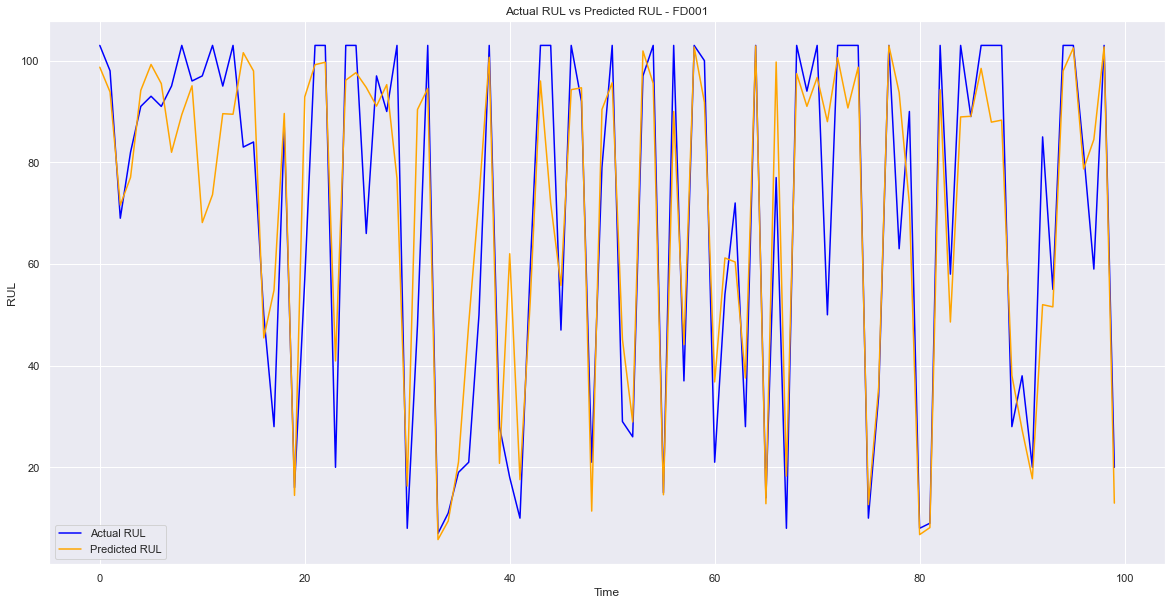

In [88]:

plt.figure(figsize=(20, 10))

# Line chart for actual RUL
plt.plot(y_test, label='Actual RUL', linestyle='-', color='blue')

# Line chart for predicted RUL
plt.plot(y_hat_test_rf, label='Predicted RUL', linestyle='-', color='orange')

plt.title('Actual RUL vs Predicted RUL - FD001')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

In [89]:
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,14.941364,0.800199,14.972684,0.817804
1,BiTRNN,15.060652,0.796996,15.046288,0.816009
2,BiGRU,14.989113,0.798920,14.819138,0.821522
3,ProgNet,14.945586,0.800086,14.867225,0.820362
4,DCNN,15.587236,0.782552,15.587694,0.802529
5,Random Forest (Ensemble),13.171194,0.844737,14.665447,0.825205
